In [304]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import Bounds

# Load the Data and Preprocess

Please use the Files from our Repo, because we did few small adjustments of preprocessing in excel

In [199]:
df_abbrev = pd.read_excel('ABBREV.xlsx')
df_agr = pd.read_excel('Agriculture_Dataset_text.xlsx')
df_nut = pd.read_excel('daily_nutrients.xlsx')

### Adjust the Type and drop not needed column

In [200]:
for col in df_agr.columns:
    if col != 'Area' and col != 'Year':
        df_agr[col] = df_agr[col].astype('float')
df_agr = df_agr.drop(columns=['Unnamed: 30'])

In [286]:
# Adjust column names
products = [el[:-29] for el in df_agr.columns[2:-1:2]]

### Search for good mapping matches in the Abbrev Dataframe
We decided to drop Camel Milk because we could not find an equivalent

In [202]:
cereals = [item for item  in list(df_abbrev['Shrt_Desc']) if 'cereals' in item.lower() and not 'rice' in item.lower()][0]

eggs = [item for item  in list(df_abbrev['Shrt_Desc']) if 'egg' in item.lower()][1]

meat_buffalo = [item for item  in list(df_abbrev['Shrt_Desc']) if 'meat' in item.lower() and 'buffalo' in item.lower()][0]
meat_cattle = [item for item  in list(df_abbrev['Shrt_Desc']) if 'meat' in item.lower()][549]
meat_chicken = [item for item  in list(df_abbrev['Shrt_Desc']) if 'chicken' in item.lower()][153]
meat_goat = [item for item  in list(df_abbrev['Shrt_Desc']) if 'meat' in item.lower() and 'goat' in item.lower()][0]
meat_pig = [item for item  in list(df_abbrev['Shrt_Desc']) if 'pork' in item.lower()][269]
meat_sheep = [item for item  in list(df_abbrev['Shrt_Desc']) if 'lamb' in item.lower()][4]

buffalo_milk = [item for item  in list(df_abbrev['Shrt_Desc']) if 'milk' in item.lower() and 'buffalo' in item.lower()][0]
cow_milk = [item for item  in list(df_abbrev['Shrt_Desc']) if 'milk' in item.lower()][12]
goat_milk = [item for item  in list(df_abbrev['Shrt_Desc']) if 'milk' in item.lower() and 'goat' in item.lower()][0]
sheep_milk = [item for item  in list(df_abbrev['Shrt_Desc']) if 'milk' in item.lower() and 'sheep' in item.lower()][0]

rice = [item for item  in list(df_abbrev['Shrt_Desc']) if 'rice' in item.lower()][66]

descriptions = [cereals, eggs, meat_buffalo, meat_cattle, meat_chicken, meat_goat, meat_pig, meat_sheep, buffalo_milk, cow_milk, goat_milk, sheep_milk, rice]

mapping = {products[i]: descriptions[i] for i in range(len(descriptions))}

df_agr = df_agr.drop(columns=['Milk, whole fresh camel-Emissions (CO2eq)-kilotonnes', 'Milk, whole fresh camel-Production-tonnes'])

### Create Mapping for the nutrition tables to combine them

In [203]:
nutrient_mapping = {
    'Calcium_(mg)': 'Calcium',                  # mg both
    'Fiber_TD_(g)': 'Dietary Fiber',            # g both
    'Lipid_Tot_(g)': 'Fat',                     # g both
    'Magnesium_(mg)': 'Magnesium',              # mg both
    'Manganese_(mg)': 'Manganese',              # mg both
    'Phosphorus_(mg)': 'Phosphorus',            # mg both
    'Potassium_(mg)': 'Potassium',              # mg both
    'Vit_C_(mg)': 'Vitamin C',                  # mg both
    'Vit_D_µg': 'Vitamin D',                    # mcg both
    'Vit_K_(µg)': 'Vitamin K',                  # mcg both
    'Copper_mg)': 'Copper',                     # mg both
    'Folic_Acid_(µg)': 'Folate/Folic Acid',     # mcg both 
    'Niacin_(mg)': 'Niacin',                    # mg both
    'Panto_Acid_mg)': 'Pantothenic Acid',       # mg both
    'Riboflavin_(mg)': 'Riboflavin',            # mg both
    'Selenium_(µg)': 'Selenium',                # mcg both
    'Sodium_(mg)': 'Sodium',                    # mg both
    'Thiamin_(mg)': 'Thiamin',                  # mg both
    'Carbohydrt_(g)': 'Total carbohydrate',     # g both
    'Vit_A_IU': 'Vitamin A',                    # mcg both
    'Vit_B6_(mg)': 'Vitamin B6',                # mg both
    'Vit_B12_(µg)': 'Vitamin B12',              # mcg both
    'Vit_E_(mg)': 'Vitamin E',                  # mg both
    'Zinc_(mg)': 'Zinc',                        # mg both
    'Cholestrl_(mg)': 'Cholesterol',            # mg both
    'Iron_(mg)': 'Iron',                        # mg both
    'Protein_(g)': 'Protein',                   # g both
    'FA_Sat_(g)': 'Saturated fat',              # g both
    'Ash_(g)': 'Added sugars',                  # g both
    'Choline_Tot_ (mg)': 'Choline'              # mg both  
}

### Combine the Daily Nutrition frame with the products from the aggriculture frame

In [204]:
# prepare food frame
df = df_abbrev[df_abbrev['Shrt_Desc'].isin(descriptions)].set_index('Shrt_Desc').transpose()
df = df.drop(['GmWt_1', 'GmWt_2', 'GmWt_Desc1', 'GmWt_Desc2'])

df_nut = df_nut.set_index('Nutrient')
vals = df_nut['Daily Value']
vals = vals.str.strip('mcg')
df_nut['Daily Value'] = vals

# combine daily nutrition frame with food frame
df['Daily Value'] = np.nan
for nutri in df.index:
    if nutri in nutrient_mapping.keys():
        df.loc[nutri, 'Daily Value'] = df_nut.loc[nutrient_mapping[nutri], 'Daily Value']

# Adjust format to numbers
for col in df.columns:
    df[col] = df[col].astype('float')


# Task 1
## Compute the fraction of the total EU GHG emission, related to agriculture as a whole

In [287]:
# Calculate total CO2 Emissions for the EU
df_eu = df_agr[df_agr['Area'] == 'European Union (27)']
CO2_cols = [col for col in df_eu.columns if '(CO2eq)' in col]
df_eu = df_eu[['Year'] + CO2_cols]
df_eu['EU Total Emissions (CO2eq)-kilotonnes'] = df_eu[CO2_cols].sum(axis=1)

# Calculate total CO2 Emissions for the world
df_total = df_agr[df_agr['Area'] == 'World']
df_total = df_total[['Year'] + CO2_cols]
df_total['World Total Emissions (CO2eq)-kilotonnes'] = df_total[CO2_cols].sum(axis=1)

/Users/niklastecklenburg/opt/miniconda3/envs/AISummit/lib/python3.10/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


<AxesSubplot:xlabel='Year'>

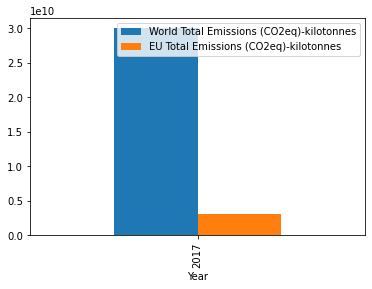

In [302]:
# Build one Dataframe and extract the results
df_task_1 = df_total[['Year', 'World Total Emissions (CO2eq)-kilotonnes']].merge(df_eu[['Year', 'EU Total Emissions (CO2eq)-kilotonnes']], 
                                                                                 how='left', 
                                                                                 on='Year')
df_task_1['EU Fraction Total Emissions (CO2eq)-kilotonnes'] = df_task_1['EU Total Emissions (CO2eq)-kilotonnes'] / df_task_1['World Total Emissions (CO2eq)-kilotonnes']

df_2017=df_task_1.loc[df_task_1['Year']==2017]
df_2017.plot(x="Year", y=["World Total Emissions (CO2eq)-kilotonnes", "EU Total Emissions (CO2eq)-kilotonnes"], kind="bar")

In 2017 the EU contribution was about 10%

### Development of the EU contribution over time

/Users/niklastecklenburg/opt/miniconda3/envs/AISummit/lib/python3.10/site-packages/pandas/core/indexes/base.py:6982: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


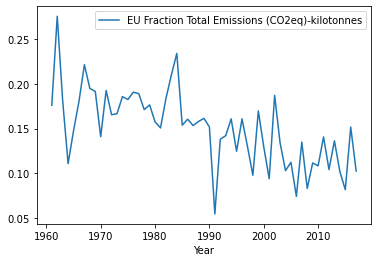

In [305]:
axes = plt.gca()

# pass the axes object to plot function
df_task_1.plot(kind='line', x='Year', y='EU Fraction Total Emissions (CO2eq)-kilotonnes', ax=axes);

# Task 2
Fraction of EU  CO2 contribution within each product type

In [293]:
# Calculate fractions

# Add prefix to Columns
eu_rename_dict = {name : 'EU, ' + name for name in CO2_cols}
df_eu = df_eu.rename(columns = eu_rename_dict)

world_rename_dict = {name : 'World, ' + name for name in CO2_cols}
df_total = df_total.rename(columns = world_rename_dict)

df_task_2 = df_eu.merge(df_total, how='left', on='Year')

for col in CO2_cols:
    df_task_2['Ratio, ' + col] = df_task_2['EU, ' + col] / df_task_2['World, ' + col]

ratio_cols = ['Ratio, ' + col for col in CO2_cols]
df_task_2 = df_task_2[['Year'] + ratio_cols]

Fractions for 2017

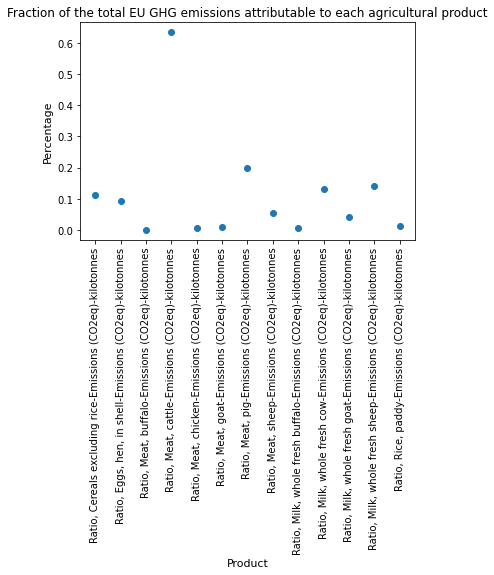

In [323]:
plt.scatter(df_task_2.columns[1:], df_task_2[df_task_2['Year'] == 2017].values.tolist()[0][1:], marker = 'o')

plt.xticks(rotation='vertical', size=10)
plt.yticks(size=10)

plt.title("Fraction of the total EU GHG emissions attributable to each agricultural product")
plt.xlabel("Product", size=11)
plt.ylabel("Percentage", size=11)

plt.show()

# Task 3

Prepare the Data by rearranging columns and dropping not needed stuff, so we can feed everything into the cost function

In [324]:
# Calculate the average CO2 Emssion per produced 100 gram
co2_mat = df_agr[CO2_cols].to_numpy()
prod_mat = df_agr.drop(columns=['Year', 'Area'] + CO2_cols).to_numpy()
co2_mat = np.divide(co2_mat, prod_mat)
co2_vec = co2_mat[-1,:] 
# scale from tons to 100 grams
co2_vec = co2_vec / 10000

df = df[["CEREALS RTE,KELLOGG,KELLOGG'S ALL-BRAN ORIGINAL",
         'EGG,WHL,RAW,FRSH', 
         'GAME MEAT,BUFFALO,H2O,RAW',
         "BEEF,GROUND,93% LN MEAT / 7% FAT",
         'CHICKEN,GROUND,RAW',
         'GAME MEAT,GOAT,CKD,RSTD',
         'PORK,FRESH,GROUND,RAW', 
         'LAMBSQUARTERS,RAW',
         'MILK,INDIAN BUFFALO,FLUID',
         'MILK,PRODUCER,FLUID,3.7% MILKFAT',
         'MILK,GOAT,FLUID,W/ ADDED VITAMIN D', 
         'MILK,SHEEP,FLUID',
         'RICE,BROWN,LONG-GRAIN,RAW',
         'Daily Value']]

df = df.dropna(subset=['Daily Value'])
daily_vec = df['Daily Value'].to_numpy()

nut_mat = df.drop(columns=['Daily Value']).to_numpy()

/var/folders/86/jj_j7bm56glckk9r2cy1875h0000gn/T/ipykernel_23012/3550610387.py:4: RuntimeWarning: divide by zero encountered in true_divide
  co2_mat = np.divide(co2_mat, prod_mat)


### Costfunction
The cost function takes the input vector and calculates the CO2 emissions, connected to this diary plan. Th function also checks whether this diary plan fullfills all requierments, so is the body supplied with everything it needs, if following this diary. If this is not the case this diary is not an option. Therefore a penalty term is introduced, increasing the cost of this plan by a big unrelative big amount.

NOTE: We are calculating in 100 grams. This is an assumption we made by looking into the water content of the products in the abbrev table.

In [325]:
def cost_function(input_vector):
    nut_vec = np.matmul(nut_mat, np.transpose(input_vector))
    constraint = nut_vec - daily_vec
    constraint = np.any(constraint < 0)
    cost = np.dot(input_vector, co2_vec) + 10000 * constraint
    return cost

Due to a lack of time we kept the optimisation rather simple and used an optimiser included within the scipy optimisation toolbox.

In [283]:
x0 = np.random.rand(13) * 20
bounds = Bounds(lb=[0,0,0,0,0,0,0,0,0,0,0,0,0], 
                ub=[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf])
res = minimize(cost_function, x0, method='SLSQP', bounds=bounds, 
               options={'xatol': 1e-8, 'disp': True})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.009864705675625992
            Iterations: 32
            Function evaluations: 448
            Gradient evaluations: 32


/var/folders/86/jj_j7bm56glckk9r2cy1875h0000gn/T/ipykernel_23012/1694885698.py:7: OptimizeWarning: Unknown solver options: xatol
  res = minimize(cost_function, x0, method='SLSQP', bounds=bounds,


In [341]:
df_diary = pd.DataFrame(list(zip(list(df.columns), res.x)), columns=['Product', 'Amount (in 100g)'])
df_diary

,Product,Amount (in 100g)
0,"CEREALS RTE,KELLOGG,KELLOGG'S ALL-BRAN ORIGINAL",1.040280e+01
1,"EGG,WHL,RAW,FRSH",1.223450e+01
2,"GAME MEAT,BUFFALO,H2O,RAW",4.602887e-14
3,"BEEF,GROUND,93% LN MEAT / 7% FAT",1.846472e-13
4,"CHICKEN,GROUND,RAW",5.643121e-01
5,"GAME MEAT,GOAT,CKD,RSTD",2.849594e-13
6,"PORK,FRESH,GROUND,RAW",1.076573e-13
7,"LAMBSQUARTERS,RAW",2.965471e-14
8,"MILK,INDIAN BUFFALO,FLUID",5.922809e+00
9,"MILK,PRODUCER,FLUID,3.7% MILKFAT",3.734678e-15


# Further Thoughts

- We where looking into using PSO and ES, but decided to keep it simple due to the time constraint
- To adjust for special diarys like lactose intollerant or vegetarian, one can simple set the nutritions to zero and the optimiser will account for this